In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## 博客
Great NLP-related blogs:
- [Sebastian Ruder](http://ruder.io/)
- [Jay Alammar](https://jalammar.github.io/)
- [Abigail See](http://www.abigailsee.com/)
- [Joyce Xu](https://medium.com/@joycex99)
- [Stephen Merity](https://smerity.com/articles/articles.html)
- [Rachael Tatman](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)

Other great technical blog posts:
- [Peter Norvig](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) (more [here](http://norvig.com/ipython/))
- [Julia Evans](https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture) (more [here](https://jvns.ca/blog/2014/08/12/what-happens-if-you-write-a-tcp-stack-in-python/))
- [Julia Ferraioli](http://blog.juliaferraioli.com/2016/02/exploring-world-using-vision-twilio.html)
- [Slav Ivanov](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b)
- find [more on twitter](https://twitter.com/math_rachel)

### 处理流程

[自然语言处理时，通常的文本清理流程是什么？ - 知乎](https://www.zhihu.com/question/268849350)

1. 获取语料库
2. 去除非文本信息
3. 拼写检查
4. 转化为小写，中文的编码 ，去掉标点符号，
5. Rare word replacement: 将词频小于5的替换成一个特殊的Token <UNK>
6. Add <BOS>, <EOS>：在句前，句后加入<BOS>和<EOS>。这个是个依赖具体模型（Model-Based）的处理策略。因为现在都用RNN，RNN的结构对于结尾不敏感（Sensitive），所以要加。
7. Long Sentence Cut-Off：将句长超过L的变成L。这个也是Model-Based，因为RNN需要Unrolling。
5. 词性标注与Named Entity Recognition
6. 词性还原与词干提取
7. 引入停用词
8. TF-IDF的特征处理
9. 建立分析模型

## NLP

NLP 包含以下的任务:

- 词性标注
- 命名实体识别（人名、地名）
- 问答系统 Question answering
- 语音辨识 Speech recognition
- 语音合成和语音识别 Text-to-speech and Speech-to-text
- 主题模型 Topic modeling
- 语义分类 Sentiment classification
- 语言模型 Language modeling
- 翻译 Translation

In [2]:
# !pip install -U nltk spacy gensim

In [3]:
# !sudo apt-get -y install protobuf-compiler libprotoc-dev

In [4]:
# !pip install pytext-nlp

```bash
$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ make
```

## 基于矩阵分解的主题模型

最佳分解是将文档聚类成两组，组与组之间具有尽可能彼此不同的单词分布，但在组中的文档中尽可能相似。 我们将这两个组称为“主题”。 我们会根据每个主题中最常出现的词汇将这些词汇分为两组。

In [5]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass

newsgroups 数据集包括18,000个新闻组帖子，其中包含20个主题

### 获取数据集

In [6]:
root = Path('/home/lab/Datasets/scikit_learn_data')
root_nltk = Path('/home/lab/Datasets/nltk_data')

In [7]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(data_home=root, subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(data_home=root, subset='test', categories=categories, remove=remove)

In [13]:
newsgroups_train.filenames.shape # 样本名
newsgroups_train.target.shape
len(newsgroups_train.data)
# 2034 篇文章也即2034个样本

(2034,)

(2034,)

2034

In [9]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

- 样本真实内容

In [14]:
newsgroups_train.target[0]
newsgroups_train.filenames[0]
print(newsgroups_train.data[0])

1

'/home/lab/Datasets/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38816'

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


- 标签与标签名

In [15]:
newsgroups_train.target[0]

1

In [16]:
newsgroups_train.target_names[1]

'comp.graphics'

- 话题数与话题单词数

In [18]:
num_topics, num_top_words = 6, 10

### 停用词

- 停用词 stop words 对文本的含义没有太大帮助的词，比如 the, 通常会被过滤掉[停用词 - 维基百科，自由的百科全书](https://zh.wikipedia.org/wiki/%E5%81%9C%E7%94%A8%E8%AF%8D)

In [19]:
from sklearn.feature_extraction import stop_words

In [20]:
dir(stop_words)

['ENGLISH_STOP_WORDS',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

In [21]:
sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]  # 字典本身无序，转换成列表后排序

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

- stop words 通常没有太多具体的含义
- stop words 通常没有一个明确的停用词表能够适用于所有的工具

### 词干和词性还原 Stemming and Lemmatization
- organize, organizes, and organizing 他们的词干是删除截尾的部分字母，最后的可能不是真正的单词，词性还原更加准确 cars -> car 名词还原
- 词形还原（lemmatization），是把一个词汇还原为一般形式（能表达完整语义），方法较为复杂；而词干提取（stemming）是抽取词的词干或词根形式（不一定能够表达完整语义），方法较为简单
- 不同语言不同

In [22]:
import nltk

In [23]:
# nltk.download('wordnet', download_dir=root_nltk)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/lab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 词干提取

In [24]:
from nltk import stem

- 基于Porter词干提取算法

In [25]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [26]:
word_list = ['feet', 'foot', 'foots', 'footing']

In [27]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [28]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

In [29]:
wl = ['organize', 'organizes', 'organizing']

In [30]:
[wnl.lemmatize(word) for word in wl]

['organize', 'organizes', 'organizing']

In [31]:
[porter.stem(word) for word in wl]

['organ', 'organ', 'organ']

- nltk 具有更多的方法，但是方法没有经过优化，Spacy 的方法较少，但是都是经过优化的

In [32]:
import spacy

In [34]:
from spacy.lemmatizer import Lemmatizer

In [39]:
# lemmatizer = Lemmatizer()

- 下载英语模型

In [40]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-1.2.0/en_core_web_md-1.2.0.tar.gz

- 词性还原

In [41]:
# [lemmatizer.lookup(word) for word in word_list]

- spacy 不提供词干提取只提供词性还原，这也是一种优化，因为 词性提取是更准确的

- 停用词 stop words 在各个库中也是不一样的

In [43]:
# nlp = spacy.load("en_core_web_sm")

In [44]:
# sorted(list(nlp.Defaults.stop_words))[:20]

上述方法长期以来被认为是标准技术，但如果使用深度学习，它们通常会损害您的表现。 

词干化，词形还原和删除停用词都涉及丢弃信息。

但是，在处理更简单的模型时，它们仍然有用

- 词频

In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/lab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
from nltk import word_tokenize

@dataclass
class LemmaTokenizer:
    wnl = stem.WordNetLemmatizer()
    
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [49]:
vectorizer = CountVectorizer(stop_words='english')

- 向量化 - 统计词频

In [51]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (文档数, 词汇量)

In [52]:
vectors.shape

(2034, 26576)

In [54]:
vocab = np.array(vectorizer.get_feature_names())

In [55]:
vocab

array(['00', '000', '0000', ..., 'zware', 'zwarte', 'zyxel'], dtype='<U80')

In [56]:
vocab.shape

(26576,)

In [57]:
vocab[3456:4567]

array(['applaud', 'apple', 'applelink', ..., 'binoculars', 'binomial',
       'bio'], dtype='<U80')

## SVD

1. 我们显然希望在一个主题中出现频率最高的单词在另一个主题中出现频率较低，否则这个单词就不能很好地分离出这两个主题。因此，我们**希望主题是正交**
2. SVD算法将一个矩阵分解为一个正交列矩阵和一个正交行矩阵(以及一个对角矩阵，其中包含每个因子的相对重要性)
3. SVD 是精确分解
- SVD的应用
    - 语义分析
    - 协同过滤/推荐(获得Netflix奖)
    - 数据压缩
    - 主成分分析

In [58]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 4min 15s, sys: 34.9 s, total: 4min 50s
Wall time: 25.4 s


In [72]:
np.diag(s)

array([[4.33926985e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.91510127e+02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.40711377e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.95236382e-15, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.83950100e-15, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.10014025e-15]])

In [67]:
U.shape
s.shape
Vh.shape

(2034, 2034)

(2034,)

(2034, 26576)

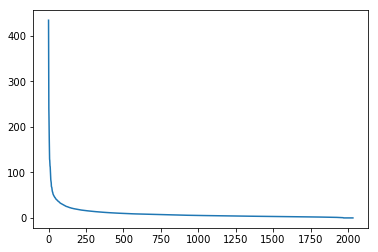

In [59]:
plt.plot(s)

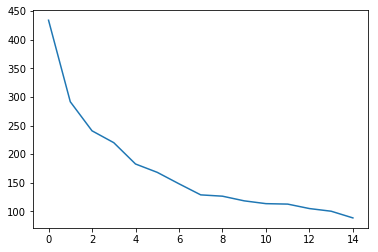

In [62]:
plt.plot(s[:15])

In [63]:
s[:10]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043,
       182.74475229, 168.15235371, 148.15722056, 128.78642   ,
       126.49055396, 118.34718466])

In [112]:
num_topics, num_top_words = 6, 10

## 主题 topics

In [92]:
def top_words(t):
    # 按 Vh 的数值对单词进行排序
    vs = [vocab[i] for i in np.argsort(t)]
    # 取出关键词，排名前几的，数值最大的
    # 按照从大到小的顺序
    kw = vs[:-num_top_words-1:-1]
    return kw
    
def show_topics(a):
    # 对每个文档计算排名靠前的词
    topic_words = [top_words(t) for t in a]
    return [' '.join(t) for t in topic_words]

- topic文章的关键词

In [113]:
show_topics(Vh[:num_topics])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative salvadorans autotheism',
 'jpeg gif file color quality image jfif format bit version',
 'graphics edu pub mail 128 3d ray ftp send image',
 'jesus god matthew people atheists atheism does graphics religious said',
 'image data processing analysis software available tools display tool user',
 'god atheists atheism religious believe religion argument true atheist example']

与其限制因子正交，另一个想法是限制它们是非负的，**更容易解释，非精确分解**

$$V = WH$$

In [97]:
num_topics = 6

In [99]:
clf = decomposition.NMF(n_components=num_topics, random_state=1)

In [103]:
vectors.shape
vectors

(2034, 26576)

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [104]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [106]:
W1.shape
W1

(2034, 6)

array([[8.84627696e-02, 2.97289582e-02, 0.00000000e+00, 2.37507804e-02,
        0.00000000e+00, 3.72347995e-02],
       [0.00000000e+00, 7.58983467e-04, 3.52199796e-03, 1.36001870e-02,
        9.86395268e-04, 1.61400988e-02],
       [0.00000000e+00, 1.64550346e-02, 2.04416652e-04, 9.72735106e-03,
        2.82118112e-03, 2.79858305e-02],
       ...,
       [9.07954483e-03, 3.00117203e-02, 3.28471200e-03, 1.43810275e-02,
        3.39512238e-03, 4.71436750e-03],
       [1.66879110e-02, 0.00000000e+00, 5.28028127e-05, 3.60103660e-02,
        0.00000000e+00, 2.95061909e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [107]:
H1.shape
H1

(6, 26576)

array([[1.21314189e-01, 0.00000000e+00, 0.00000000e+00, ...,
        3.18193652e-05, 6.36387303e-05, 2.94728045e-04],
       [1.19659887e-01, 1.21895163e-01, 1.66521367e-04, ...,
        1.16507442e-04, 2.33014883e-04, 5.20256298e-02],
       [6.26357335e-02, 5.25135886e-01, 8.69181875e-04, ...,
        3.11413247e-04, 6.22826494e-04, 0.00000000e+00],
       [2.38710449e-03, 2.23453097e-01, 0.00000000e+00, ...,
        1.55491031e-04, 3.10982062e-04, 0.00000000e+00],
       [1.27275233e-01, 1.93687336e-01, 5.04255146e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

- 两种方法的主题关键词对比
- **SVD和NMF都可以获得主题与主题对应的关键词**

In [114]:
show_topics(H1)
show_topics(Vh[:num_topics])
# 有一个不重合

['jpeg image gif file color images format quality version files',
 'edu graphics pub mail 128 ray ftp send 3d com',
 'space launch satellite nasa commercial satellites year market data earth',
 'jesus matthew prophecy people said messiah david isaiah psalm lord',
 'image data available software processing ftp edu analysis images display',
 'god atheists atheism religious believe people religion does argument true']

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative salvadorans autotheism',
 'jpeg gif file color quality image jfif format bit version',
 'graphics edu pub mail 128 3d ray ftp send image',
 'jesus god matthew people atheists atheism does graphics religious said',
 'image data processing analysis software available tools display tool user',
 'god atheists atheism religious believe religion argument true atheist example']

## 基于 TF-IDF 的主题模型

In [119]:
tf = TfidfVectorizer(stop_words='english')
tfidf = tf.fit_transform(newsgroups_train.data)

In [148]:
tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [152]:
num_topics = 6
clf = decomposition.NMF(n_components=num_topics, random_state=1)

In [153]:
W1 = clf.fit_transform(tfidf)
H1 = clf.components_

In [151]:
show_topics(H1)

['don people just think like know say religion ve time',
 'thanks graphics files image file program windows format know ftp',
 'space nasa launch shuttle orbit lunar moon earth station data',
 'ico bobbe tek beauchaine bronx manhattan sank queens vice blew',
 'god jesus bible believe atheism christian does belief exist faith',
 'objective morality values moral subjective science absolute claim freedom goal']

In [156]:
H1

array([[0.00000000e+00, 2.84560108e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.62253968e-02, 5.37739098e-03, 1.29560860e-03, ...,
        1.34500220e-06, 2.69000440e-06, 2.70361504e-03],
       [3.42515702e-02, 5.92040562e-02, 3.51409881e-03, ...,
        6.36500137e-05, 1.27300027e-04, 3.91269990e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.71932455e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.37529941e-06, 1.67505988e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

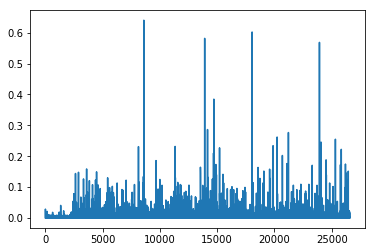

In [158]:
plt.plot(H1[0])

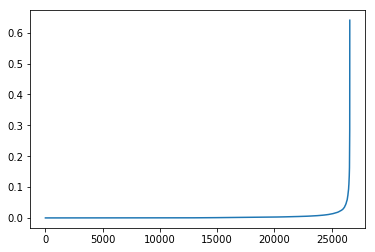

In [157]:
plt.plot(sorted(H1[0]))

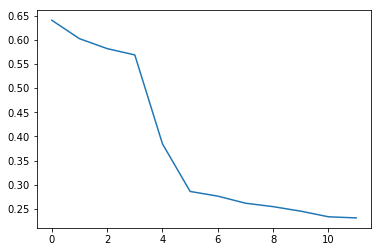

In [168]:
plt.plot(sorted(H1[0], reverse=True)[:12])

- 基本上也就数值最大的10个词有很强的区分性

In [169]:
clf.reconstruction_err_

43.645567658711265

- 可以基于 **词频** 进行主题建模也可以基于 **TF_IDF** 进行主题建模

## Truncated SVD

In [170]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 2min 48s, sys: 396 ms, total: 2min 49s
Wall time: 2min 49s


In [171]:
# !pip install fbpca

[facebook/fbpca: Fast Randomized PCA/SVD](https://github.com/facebook/fbpca)

In [172]:
from sklearn.utils.extmath import randomized_svd
import fbpca

In [175]:
# Computes a truncated randomized SVD
%time u, s, v = randomized_svd(tfidf, 10)

CPU times: user 308 ms, sys: 603 ms, total: 912 ms
Wall time: 81.9 ms


In [176]:
%time u, s, v = fbpca.pca(tfidf, 10)

CPU times: user 81 ms, sys: 146 ms, total: 227 ms
Wall time: 21.3 ms


- SVD和NMF都可以进行稀疏矩阵的分解